# White-Box Uncertainty Quantification Demo

Content
1. [Introduction](#section1')
2. [Set up LLM and Prompts](#section2')
3. [Generate Responses and Confidence Scores](#section3')<br>
4. [Performance Evaluation](#section4')

In [1]:
import warnings

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm.utils import load_example_dataset, math_postprocessor, plot_model_accuracies, Tuner
from uqlm.quantifiers import WhiteBoxUQ

warnings.filterwarnings("ignore")

2025-03-12 18:27:00.463681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741804020.486786   34469 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741804020.493735   34469 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 18:27:00.517439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id='section1'></a>
## 1. Introduction

White-box Uncertainty Quantification (UQ) methods leverage token probabilities to estimate uncertainty.  They are significantly faster and cheaper than black-box methods, but require access to the LLM's internal probabilities, meaning they are not necessarily compatible with all LLMs/APIs. This demo provides an illustration of how to use state-of-the-art white-box UQ methods with `uqlm`.

**Pros:**

*   ✅  **Minimal Latency Impact:** Token probabilities are typically already returned by the LLM.
*   ✅  **No Added Cost:**  Doesn't require additional LLM calls.

**Cons:**

*   ⚠️  **Limited Compatibility:** Requires access to token probabilities, not available for all LLMs/APIs. For example, 

**Available Scorers:**

*   Minimum token probability ([Manakul et al., 2023](https://arxiv.org/abs/2303.08896))
*   Perplexity ([Fadeeva et al., 2024](https://arxiv.org/pdf/2403.04696))
*   Length-Normalized Joint Token Probability ([Malinin & Gales, 2021](https://arxiv.org/pdf/2002.07650))

<a id='section2'></a>
## 2. Set up LLM and Prompts

In [2]:
# Load example dataset (SVAMP)
svamp = (
    load_example_dataset("svamp")
    .rename(columns={"question_concat": "question", "Answer": "answer"})[
        ["question", "answer"]
    ]
    .head(20)
)
svamp.head()

Loading dataset - svamp...
Processing dataset...
Dataset ready!


,question,answer
0,There are 87 oranges and 290 bananas in Philip...,145
1,Marco and his dad went strawberry picking. Mar...,19
2,Edward spent $ 6 to buy 2 books each book cost...,3
3,Frank was reading through his favorite book. T...,198
4,There were 78 dollars in Olivia's wallet. She ...,63


In [3]:
# Define prompts
MATH_INSTRUCTION = (
    "When you solve this math problem only return the answer with no additional text.\n"
)
prompts = [MATH_INSTRUCTION + prompt for prompt in svamp.question]

In [4]:
# Instantiate BaseChatModel
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model="gemini-pro")

Note that although we use `ChatVertexAI` in this example, any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used.

<a id='section3'></a>
## 3. Generate responses and confidence scores

#### `WhiteBoxUQ()` - Class for computing token probability-based confidence scores on LLM responses for the provided prompts (hallucination detection).

**Class Attributes:**
- `llm` (**BaseChatModel, default=None**) A langchain llm (`BaseChatModel`). User is responsible for specifying temperature and other relevant parameters to the constructor of their `BaseChatModel` object.
- `system_prompt` - (**str or None, default="You are a helpful assistant."**) Optional argument for user to provide custom system prompt
- `max_calls_per_min` - (**int, default=None**) Specifies how many api calls to make per minute to avoid a rate limit error. By default, no limit is specified.
- `scorers` - (**subset of {"imperplexity", "geometric_mean_probability", "min_probability", "max_probability"}, default=None**) Specifies which black box (consistency) scorers to include. If None, defaults to all. 

**Class Methods:**
1. `evaluate` - Generate responses and evaluate token probability-based confidence scores on LLM responses for the provided prompts.

    **Method Attributes:**
    - `prompts` - (**list of str**) A list of input prompts for the model.

    **Returns:**
        `UQResult`

In [5]:
wbuq = WhiteBoxUQ(llm=llm)
results = await wbuq.evaluate(prompts=prompts)

Generating responses...


In [6]:
result_df = results.to_df()
result_df.head()

,prompt,response,logprob,normalized_probability,min_probability,max_probability
0,When you solve this math problem only return t...,145,"[{'token': '1', 'logprob': -0.0545064397156238...",0.981767,0.946952,0.999905
1,When you solve this math problem only return t...,19,"[{'token': '1', 'logprob': -0.0217719040811061...",0.987856,0.978463,0.997338
2,When you solve this math problem only return t...,$ 9.00,"[{'token': '$', 'logprob': -0.0915694460272789...",0.285509,0.017911,0.985661
3,When you solve this math problem only return t...,198,"[{'token': '1', 'logprob': -0.0271051470190286...",0.990932,0.973259,0.999923
4,When you solve this math problem only return t...,63 dollars.,"[{'token': '6', 'logprob': -0.1229766160249710...",0.598953,0.349287,0.999001


<a id='section4'></a>
## 4. Evaluate performance

In [7]:
# Populate correct answers and grade responses
result_df["answer"] = svamp.answer
result_df["response_correct"] = [
    math_postprocessor(r) == a for r, a in zip(result_df["response"], svamp["answer"])
]
result_df.head(5)

,prompt,response,logprob,normalized_probability,min_probability,max_probability,answer,response_correct
0,When you solve this math problem only return t...,145,"[{'token': '1', 'logprob': -0.0545064397156238...",0.981767,0.946952,0.999905,145,True
1,When you solve this math problem only return t...,19,"[{'token': '1', 'logprob': -0.0217719040811061...",0.987856,0.978463,0.997338,19,True
2,When you solve this math problem only return t...,$ 9.00,"[{'token': '$', 'logprob': -0.0915694460272789...",0.285509,0.017911,0.985661,3,False
3,When you solve this math problem only return t...,198,"[{'token': '1', 'logprob': -0.0271051470190286...",0.990932,0.973259,0.999923,198,True
4,When you solve this math problem only return t...,63 dollars.,"[{'token': '6', 'logprob': -0.1229766160249710...",0.598953,0.349287,0.999001,63,True


In [8]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.7


Next we will plot filtered LLM accuracy at various confidence score thresholds. The idea is to measure the LLM's performance when we consider responses with confidence scores above a given threshold.

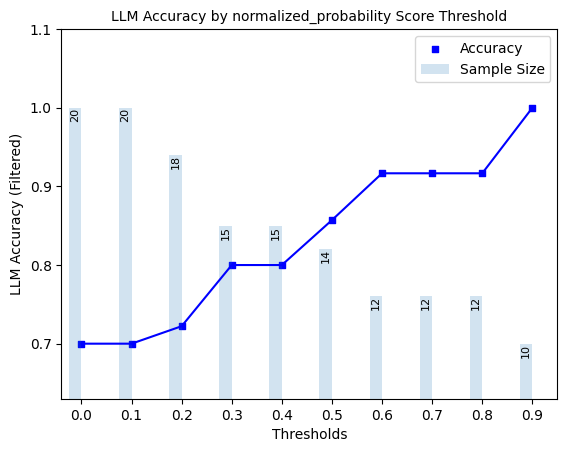

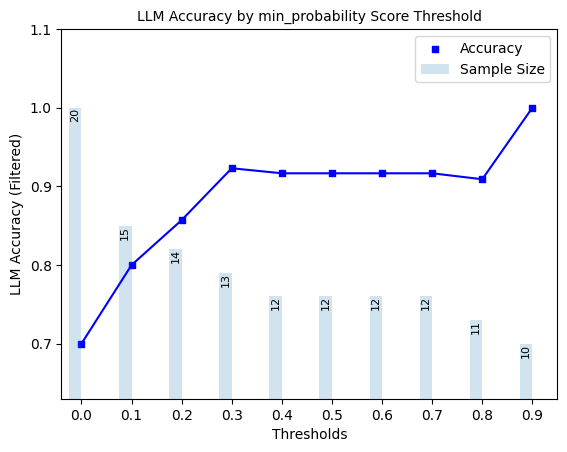

In [9]:
for scorer in ["normalized_probability", "min_probability"]:
    plot_model_accuracies(
        scores=result_df[scorer],
        correct_indicators=result_df.response_correct,
        title=f"LLM Accuracy by {scorer} Score Threshold",
    )

Lastly, we will compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we can compute precision, recall, and F1-score for white box scorer predictions of whether responses are correct.

In [10]:
# instantiate UQLM tuner object for threshold selection
t = Tuner()

correct_indicators = (
    result_df.response_correct
) * 1  # Whether responses is actually correct
for scorer in ["normalized_probability", "min_probability"]:
    y_scores = result_df[scorer]  # confidence score

    # Solve for threshold that maximizes F1-score
    best_threshold = t.tune_threshold(
        y_scores=y_scores,
        correct_indicators=correct_indicators,
        thresh_objective="fbeta_score",
    )
    y_pred = [
        (s > best_threshold) * 1 for s in y_scores
    ]  # predicts whether response is correct based on confidence score
    print(f"{scorer} score F1-optimal threshold: {best_threshold}")
    print(" ")

    # evaluate precision, recall, and f1-score of predictions of correctness
    print(
        f"{scorer} precision: {precision_score(y_true=correct_indicators, y_pred=y_pred)}"
    )
    print(f"{scorer} recall: {recall_score(y_true=correct_indicators, y_pred=y_pred)}")
    print(f"{scorer} f1-score: {f1_score(y_true=correct_indicators, y_pred=y_pred)}")
    print(" ")
    print(" ")

normalized_probability score F1-optimal threshold: 0.51
 
normalized_probability precision: 0.9230769230769231
normalized_probability recall: 0.8571428571428571
normalized_probability f1-score: 0.8888888888888888
 
 
min_probability score F1-optimal threshold: 0.21
 
min_probability precision: 0.9230769230769231
min_probability recall: 0.8571428571428571
min_probability f1-score: 0.8888888888888888
 
 
